## Data exploration for Kaggle - Optiver Realized Volatility Prediction
@LaurentMombaerts 13/07/2021

In [2]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


**Lib Import / Data loading**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import glob
from sklearn.metrics import r2_score

# Models
from persistence import *

# Load dataset
train = pd.read_csv(r'C:\Users\laurent\ownCloud\Data\Kaggle\optiver-realized-volatility-prediction\train.csv') 
train['row_id'] = train['stock_id'].astype(str) + '-' + train['time_id'].astype(str)
train = train[['row_id','target']]

**Functions**

In [6]:
# Competition metric
def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))

# Prediction function (chose here which prediction strategy to use)
def prediction_function(files,column_name):
    
    # Naive prediction (persistence model)
    prediction = past_realized_volatility_per_stock(list_file=files,prediction_column_name=column_name)
    
    # Option B
    
    return prediction

**Data analysis functions**

In [75]:
def select_stock_book(book_path,stock_id,time_id=-1):
    
    stock_path = str(book_path) + '\stock_id=' + str(stock_id)
    book = pd.read_parquet(stock_path)
    
    if time_id != -1: 
        book = book[book['time_id'] == time_id]
        
    return book

def select_stock_trades(trade_path,stock_id,time_id=-1):
    
    trade_path = str(trade_path) + '\stock_id=' + str(stock_id)
    trades = pd.read_parquet(trade_path)
    
    if time_id != -1: 
        trades = trades[trades['time_id'] == time_id]
        
    return trades

def log_return(list_stock_prices): # Stock prices are estimated through wap values
    return np.log(list_stock_prices).diff() 

def realized_volatility(series_log_return):
    return np.sqrt(np.sum(series_log_return**2))

def compute_wap(book_pd):
    wap = (book_pd['bid_price1'] * book_pd['ask_size1'] + book_pd['ask_price1'] * book_pd['bid_size1']) / (book_pd['bid_size1']+ book_pd['ask_size1'])
    return wap

**Data exploration**

In [76]:
# Paths
books_path = r'C:\Users\laurent\ownCloud\Data\Kaggle\optiver-realized-volatility-prediction\book_train.parquet'
trades_path = r'C:\Users\laurent\ownCloud\Data\Kaggle\optiver-realized-volatility-prediction\trade_train.parquet'

list_order_book_file_train = glob.glob(r'C:\Users\laurent\ownCloud\Data\Kaggle\optiver-realized-volatility-prediction\book_train.parquet\*') 
list_trade_file_train = glob.glob(r'C:\Users\laurent\ownCloud\Data\Kaggle\optiver-realized-volatility-prediction\trade_train.parquet\*')

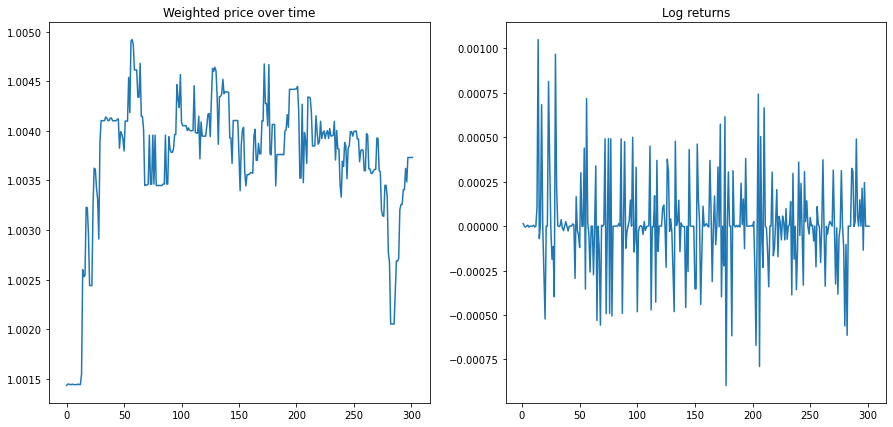

0.004499364172786559


,time_id,seconds_in_bucket,price,size,order_count
0,5,21,1.002301,326,12
1,5,46,1.002778,128,4
2,5,50,1.002818,55,1
3,5,57,1.003155,121,5
4,5,68,1.003646,4,1


In [83]:
# Select specific book
book = select_stock_book(books_path,stock_id=0,time_id=5)
book['wap'] = compute_wap(book)
book['log_return'] = log_return(book['wap'])

plt.figure(figsize=(15,7))
plt.subplot(121)
plt.plot(book['wap'])
plt.title('Weighted price over time')

plt.subplot(122)
plt.plot(book['log_return'])
plt.title('Log returns')
plt.show()

# Computed volatility
volatility = realized_volatility(book['log_return'])
print(volatility)

# Trades
trades = select_stock_trades(trades_path,stock_id=0,time_id=5)
trades.head(5)

**Main evaluation code**

In [ ]:
# Glob book file train (contains all paths for each file in this folder)
list_order_book_file_train = glob.glob(r'C:\Users\laurent\ownCloud\Data\Kaggle\optiver-realized-volatility-prediction\book_train.parquet\*') 

# Compute predictions
df_past_realized_train = prediction_function(files=list_order_book_file_train,column_name='pred') 

In [ ]:
# Merge and evaluate results
df_joined = train.merge(df_past_realized_train[['row_id','pred']], on = ['row_id'], how = 'left')
print(df_joined.head(5))

# Estimate performances
R2 = round(r2_score(y_true = df_joined['target'], y_pred = df_joined['pred']),3)
RMSPE = round(rmspe(y_true = df_joined['target'], y_pred = df_joined['pred']),3)

print('--')
print(f'Performance of prediction: R2 score: {R2}, RMSPE: {RMSPE}')

**Simple estimation of stock 10min+10min variability by looking at how much the persistence holds for this specific stock**